In [214]:
import pandas as pd
import scipy as scp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.offline as py
import os

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

In [215]:
# Read 2015 data
happiness2015 = pd.read_csv('Happiness2015.csv')
happiness2015 = happiness2015.drop(['Region', 'Standard Error', 'Happiness Rank', 'Dystopia Residual'], axis=1)


In [216]:
 #Plot Happiness Score World Map
data = dict(type='choropleth', locations=happiness2015['Country'], locationmode='country names',
            z=happiness2015['Happiness Score'], colorbar={'title': 'Happiness Scale'})

layout = dict(title='Global Happiness Ranking',
              geo=dict(showframe=False,
                       projection={'type': 'natural earth'}))
choromap = go.Figure(data=[data], layout=layout)
fig = dict(data=data, layout=layout)
#py.iplot(fig, validate=False, filename='world-heatmap')
# Uncomment this to show World Map
#iplot(choromap)

Text(0.5, 1, 'Heatmap of Correlation Matrix')

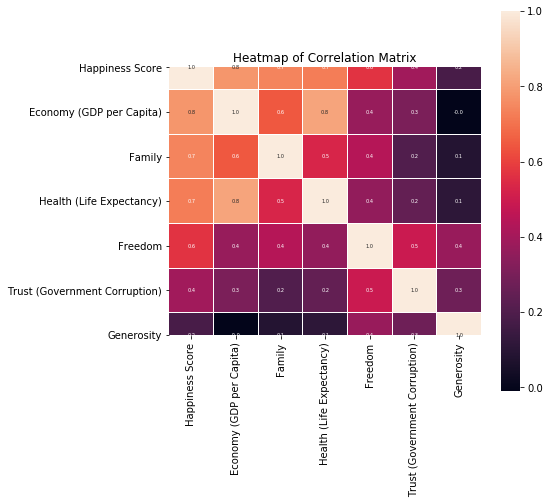

In [217]:
 ########## --------------- Correlation Investigation with Original Dataset --------------- ##################

#Plot correlation heatmap
f, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(happiness2015.corr(), annot=True, linewidths=0.1, fmt='.1f', ax=ax, square=True, annot_kws={'size':5})
plt.title('Heatmap of Correlation Matrix')
# Uncomment this to show Correlation Heat Map
#plt.show()

In [218]:
# Perform Pearson test for correlation
corr_test_GDP = scp.stats.pearsonr(happiness2015['Happiness Score'], happiness2015['Economy (GDP per Capita)'])
print("GDP per Capita vs Happiness score correlation P-value: " + str(corr_test_GDP[1]) )

corr_test_Health = scp.stats.pearsonr(happiness2015['Happiness Score'], happiness2015['Health (Life Expectancy)'])
print("Health (Life Expectancy) vs Happiness score correlation P-value: " + str(corr_test_Health[1]))



GDP per Capita vs Happiness score correlation P-value: 1.050538413195872e-33
Health (Life Expectancy) vs Happiness score correlation P-value: 5.7888955059012864e-27


In [219]:
 ######################## -----Collecting important feature and merge with Happiness data---- ##################

happiness2015['Year'] = 2015
happiness2015 = happiness2015[['Country', 'Happiness Score', 'Year']]

# Read features
lifeExpectancy = pd.read_csv("Life_expectancy_Index.csv", skiprows=1, encoding='iso-8859-1')
GDPperCapita = pd.read_csv("API_NY.GDP.PCAP.CD_DS2_en_csv_v2_422141.csv", skiprows=4,
                           encoding='iso-8859-1')
EducationIndex = pd.read_csv("Education_Index.csv", skiprows=1, encoding='iso-8859-1')

In [220]:
# Data cleansing - filter unwanted rows
lifeExpectancy = lifeExpectancy[lifeExpectancy['HDI Rank (2017)'].str.contains('^[0-9]+$', na=False)]
lifeExpectancy = lifeExpectancy[pd.to_numeric(lifeExpectancy['2015'], errors='coerce').notnull()]

GDPperCapita = GDPperCapita[pd.to_numeric(GDPperCapita['2015'], errors='coerce').notnull()]

EducationIndex = EducationIndex[EducationIndex['HDI Rank (2017)'].str.contains('^[0-9]+$', na=False)]
EducationIndex = EducationIndex[pd.to_numeric(EducationIndex['2015'], errors='coerce').notnull()]

# Data cleansing - filter needed columns
lifeExpectancy = lifeExpectancy[['Country', '2015']]
lifeExpectancy['lifeExpectancy'] = lifeExpectancy['2015']
del lifeExpectancy['2015']

EducationIndex = EducationIndex[['Country', '2015']]
EducationIndex['EducationIndex'] = EducationIndex['2015']
del EducationIndex['2015']

GDPperCapita['GDPperCapita'] = GDPperCapita['2015']
GDPperCapita = GDPperCapita[['Country Name', '2015']]
GDPperCapita['Country'] = GDPperCapita['Country Name']
del GDPperCapita['Country Name']



In [221]:
#Merge features with Happiness score
data2015 = happiness2015.merge(GDPperCapita, on='Country').merge(EducationIndex, on='Country').merge(
    lifeExpectancy, on='Country')

data2015['GDPperCapita'] = data2015['2015']
del data2015['2015']
del data2015['Year']

data2015["EducationIndex"] = pd.to_numeric(data2015["EducationIndex"])
data2015["lifeExpectancy"] = pd.to_numeric(data2015["lifeExpectancy"])
data2015["GDPperCapita"] = pd.to_numeric(data2015["GDPperCapita"])

######################## -------------------------------- ##################

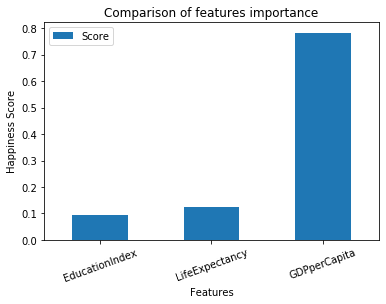

In [222]:
########## --------------- Correlation Investigation with Education --------------- ##################

#Perform Random Forest Regressor to get important features
# X is Feature
X = data2015.drop(['Country', 'Happiness Score'], axis=1)

# y is the 'target'
y = data2015['Happiness Score']

arr = RandomForestRegressor(n_estimators=35, random_state=1, n_jobs=-1).fit(X, y).feature_importances_
header = (['EducationIndex','LifeExpectancy', 'GDPperCapita'])
header = pd.DataFrame(header)
frame = pd.DataFrame(arr)
# frame
res = pd.concat([header, frame], axis=1)
res.columns = ['Features', 'Score']
ax = res.plot.bar(x='Features', y='Score', rot=0)
plt.xticks(rotation=20)
plt.title('Comparison of features importance')
plt.ylabel('Happiness Score')
plt.show()


######################## -------------------------------- ##################


In [223]:
######################## -----Peforming Machine Learning for Prediction---- ##################
X_2015 = data2015.drop(['Country', 'Happiness Score'], axis=1)
y_2015 = data2015.drop(['Country', 'EducationIndex', 'lifeExpectancy', 'GDPperCapita'], axis=1)

X_2015_train, X_2015_test, y_2015_train, y_2015_test = train_test_split(X_2015, y_2015, test_size=0.2, random_state=27)


In [224]:
# Perform tuning for kNN
# Tuning for KNR
rmse_val = []  # to store rmse values for different k
temp_rmse_min = 1
ideal_neighbors = 0
for K in range(20):
    K = K + 1
    model = Pipeline(steps=[('scaler', StandardScaler()),
                            ('classifier', KNeighborsRegressor(n_neighbors=K))])

    model.fit(X_2015_train, np.array(y_2015_train).reshape(-1))  # fit the model
    pred = model.predict(X_2015_test)  # make prediction on test set
    error = sqrt(mean_squared_error(y_2015_test, pred))  # calculate rmse
    rmse_val.append(error)  # store rmse values
    if(temp_rmse_min > error):
        temp_rmse_min = error
        ideal_neighbors = K
    print('RMSE value for KNeighborsRegressor with k= ', K, 'is:', error)
  

RMSE value for KNeighborsRegressor with k=  1 is: 0.7367992087903419
RMSE value for KNeighborsRegressor with k=  2 is: 0.5804871995909029
RMSE value for KNeighborsRegressor with k=  3 is: 0.5372920709886989
RMSE value for KNeighborsRegressor with k=  4 is: 0.5136642466955758
RMSE value for KNeighborsRegressor with k=  5 is: 0.5225437681473483
RMSE value for KNeighborsRegressor with k=  6 is: 0.5493809113925138
RMSE value for KNeighborsRegressor with k=  7 is: 0.5093858350497759
RMSE value for KNeighborsRegressor with k=  8 is: 0.49672156435975257
RMSE value for KNeighborsRegressor with k=  9 is: 0.4886839712706598
RMSE value for KNeighborsRegressor with k=  10 is: 0.4777657251709754
RMSE value for KNeighborsRegressor with k=  11 is: 0.47948655836965615
RMSE value for KNeighborsRegressor with k=  12 is: 0.5006081088558825
RMSE value for KNeighborsRegressor with k=  13 is: 0.4703155074294269
RMSE value for KNeighborsRegressor with k=  14 is: 0.47091122306392136
RMSE value for KNeighborsR

In [225]:
# Perform tuning for RandomForestRegressor
# Tuning for RandomForestRegressor
rmse_val = []  # to store rmse values for different k
temp_rmse_min = 1
ideal_estimator = 0
for K in range(40):
    K = K + 1
    model = Pipeline(steps=[('scaler', StandardScaler()),
                         ('classifier', RandomForestRegressor(n_estimators=K,
                                                              oob_score=False,
                                                              random_state=1))])

    model.fit(X_2015_train, np.array(y_2015_train).reshape(-1))  # fit the model
    pred = model.predict(X_2015_test)  # make prediction on test set
    error = sqrt(mean_squared_error(y_2015_test, pred))  # calculate rmse
    rmse_val.append(error)  # store rmse values
    if(temp_rmse_min > error):
        temp_rmse_min = error
        ideal_estimator = K
    print('RMSE value for RandomForestRegressor with k= ', K, 'is:', error)
 

RMSE value for RandomForestRegressor with k=  1 is: 0.7999430766785385
RMSE value for RandomForestRegressor with k=  2 is: 0.6169798453998555
RMSE value for RandomForestRegressor with k=  3 is: 0.5530924397544954
RMSE value for RandomForestRegressor with k=  4 is: 0.5589264469929367
RMSE value for RandomForestRegressor with k=  5 is: 0.5418903743173314
RMSE value for RandomForestRegressor with k=  6 is: 0.5042182832469424
RMSE value for RandomForestRegressor with k=  7 is: 0.5132298913652423
RMSE value for RandomForestRegressor with k=  8 is: 0.5012869219568767
RMSE value for RandomForestRegressor with k=  9 is: 0.4976398462265202
RMSE value for RandomForestRegressor with k=  10 is: 0.5099686406480739
RMSE value for RandomForestRegressor with k=  11 is: 0.5093346864029449
RMSE value for RandomForestRegressor with k=  12 is: 0.5073288220606192
RMSE value for RandomForestRegressor with k=  13 is: 0.5114071332822293
RMSE value for RandomForestRegressor with k=  14 is: 0.5158973432603318
R

In [228]:
# define model

model1 = Pipeline(steps=[('scaler', StandardScaler()),
                         ('classifier', RandomForestRegressor(n_estimators=ideal_estimator,
                                                              oob_score=False,
                                                              random_state=1))])
model2 = Pipeline(steps=[('scaler', StandardScaler()),
                         ('classifier', KNeighborsRegressor(n_neighbors=ideal_neighbors))])



In [229]:
# cross validation, metrics computed on validation fold
cv_scores = cross_validate(model1, X_2015_train, np.array(y_2015_train).reshape(-1),
                           cv=3, scoring=['r2', 'neg_mean_squared_error'])
# cv_scores['test_r2'].mean(), cv_scores['test_r2'].std()
print("cross-validation r2 score: %0.2f (+/- %0.2f)" % \
      (cv_scores['test_r2'].mean(), cv_scores['test_r2'].std() * 2))
print("cross-validation neg_mean_squared_error score: %0.2f (+/- %0.2f)" % \
      (cv_scores['test_neg_mean_squared_error'].mean(), \
       cv_scores['test_neg_mean_squared_error'].std() * 2))



cross-validation r2 score: 0.72 (+/- 0.05)
cross-validation neg_mean_squared_error score: -0.36 (+/- 0.06)


In [230]:
# fit model on train
model1 = model1.fit(X_2015_train, np.array(y_2015_train).reshape(-1))
# compute r2 score
RandomForestRegressor_score= model1.score(X_2015_test, np.array(y_2015_test).reshape(-1))
print("Random Forest Regressor score: " + str(RandomForestRegressor_score))



Random Forest Regressor score: 0.8631460300116962


In [231]:
# same as calling model1.score, but here we explicitly call r2_score
metrics.r2_score(np.array(y_2015_test).reshape(-1), model1.predict(X_2015_test))


0.8631460300116963

In [232]:
# cross validation, metrics computed on validation fold for model2
cv_scores = cross_validate(model2, X_2015_train, np.array(y_2015_train).reshape(-1), 
               cv=3, scoring=['r2', 'neg_mean_squared_error']) 

In [233]:
#cv_scores['test_r2'].mean(), cv_scores['test_r2'].std()
print("cross-validation r2 score: %0.2f (+/- %0.2f)" % \
      (cv_scores['test_r2'].mean(), cv_scores['test_r2'].std() * 2))
print("cross-validation neg_mean_squared_error score: %0.2f (+/- %0.2f)" % \
      (cv_scores['test_neg_mean_squared_error'].mean(), \
       cv_scores['test_neg_mean_squared_error'].std() * 2))

cross-validation r2 score: 0.64 (+/- 0.09)
cross-validation neg_mean_squared_error score: -0.46 (+/- 0.10)


In [234]:
# fit model on train 
model2 = model2.fit(X_2015_train, np.array(y_2015_train).reshape(-1))
# compute r2 score
KNeighborsRegressor_score=model2.score(X_2015_test, np.array(y_2015_test).reshape(-1))
print("K Neighbors Regressor score: " + str(KNeighborsRegressor_score))



K Neighbors Regressor score: 0.8634544518057322


In [235]:
# Perform tuning for RandomForestRegressor
# Tuning for RandomForestRegressor
rmse_val = []  # to store rmse values for different k
temp_rmse_min = 1
ideal_neighbors = 0
for K in range(40):
    K = K + 1
    model = Pipeline(steps=[('scaler', StandardScaler()),
                         ('classifier', RandomForestRegressor(n_estimators=K,
                                                              oob_score=False,
                                                              random_state=1))])

    model.fit(X_2015_train, np.array(y_2015_train).reshape(-1))  # fit the model
    pred = model.predict(X_2015_test)  # make prediction on test set
    error = sqrt(mean_squared_error(y_2015_test, pred))  # calculate rmse
    rmse_val.append(error)  # store rmse values
    if(temp_rmse_min > error):
        temp_rmse_min = error
        ideal_neighbors = K
    print('RMSE value for RandomForestRegressor with k= ', K, 'is:', error)
   

RMSE value for RandomForestRegressor with k=  1 is: 0.7999430766785385
RMSE value for RandomForestRegressor with k=  2 is: 0.6169798453998555
RMSE value for RandomForestRegressor with k=  3 is: 0.5530924397544954
RMSE value for RandomForestRegressor with k=  4 is: 0.5589264469929367
RMSE value for RandomForestRegressor with k=  5 is: 0.5418903743173314
RMSE value for RandomForestRegressor with k=  6 is: 0.5042182832469424
RMSE value for RandomForestRegressor with k=  7 is: 0.5132298913652423
RMSE value for RandomForestRegressor with k=  8 is: 0.5012869219568767
RMSE value for RandomForestRegressor with k=  9 is: 0.4976398462265202
RMSE value for RandomForestRegressor with k=  10 is: 0.5099686406480739
RMSE value for RandomForestRegressor with k=  11 is: 0.5093346864029449
RMSE value for RandomForestRegressor with k=  12 is: 0.5073288220606192
RMSE value for RandomForestRegressor with k=  13 is: 0.5114071332822293
RMSE value for RandomForestRegressor with k=  14 is: 0.5158973432603318
R

In [175]:
# Polynomial Regression Model
polynomialRegression_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=True),
    LinearRegression(fit_intercept=False)
)
polynomialRegression_model = polynomialRegression_model.fit(X_2015_train, np.array(y_2015_train).reshape(-1))
polynomialRegression_model_score=polynomialRegression_model.score(X_2015_test, np.array(y_2015_test).reshape(-1))
print("Polynomial Regression model score: " + str(polynomialRegression_model_score))



Polynomial Regression model score: 0.8039448698439376


In [176]:
# cross validation, metrics computed on validation fold
cv_scores = cross_validate(polynomialRegression_model, X_2015_train, np.array(y_2015_train).reshape(-1),
                           cv=3, scoring=['r2', 'neg_mean_squared_error'])
# cv_scores['test_r2'].mean(), cv_scores['test_r2'].std()
print("cross-validation r2 score: %0.2f (+/- %0.2f)" % \
      (cv_scores['test_r2'].mean(), cv_scores['test_r2'].std() * 2))
print("cross-validation neg_mean_squared_error score: %0.2f (+/- %0.2f)" % \
      (cv_scores['test_neg_mean_squared_error'].mean(), \
       cv_scores['test_neg_mean_squared_error'].std() * 2))


cross-validation r2 score: 0.60 (+/- 0.07)
cross-validation neg_mean_squared_error score: -0.51 (+/- 0.10)


In [177]:
# multiple_LinearRegression_model
multiple_LinearRegression_model = LinearRegression()



In [178]:
# cross validation, metrics computed on validation fold
cv_scores = cross_validate(multiple_LinearRegression_model, X_2015_train, np.array(y_2015_train).reshape(-1),
                           cv=3, scoring=['r2', 'neg_mean_squared_error'])
# cv_scores['test_r2'].mean(), cv_scores['test_r2'].std()
print("cross-validation r2 score: %0.2f (+/- %0.2f)" % \
      (cv_scores['test_r2'].mean(), cv_scores['test_r2'].std() * 2))
print("cross-validation neg_mean_squared_error score: %0.2f (+/- %0.2f)" % \
      (cv_scores['test_neg_mean_squared_error'].mean(), \
       cv_scores['test_neg_mean_squared_error'].std() * 2))



cross-validation r2 score: 0.61 (+/- 0.07)
cross-validation neg_mean_squared_error score: -0.50 (+/- 0.09)


In [179]:
multiple_LinearRegression_model = multiple_LinearRegression_model.fit(X_2015_train,
                                                                      np.array(y_2015_train).reshape(-1))
LinearRegression_model_score = multiple_LinearRegression_model.score(X_2015_test, np.array(y_2015_test).reshape(-1))
print("Linear Regression model score: " + str(LinearRegression_model_score))

print("Done")



Linear Regression model score: 0.8238606993727743
Done


In [180]:
###########----------Perform Prediction using K Neighbors Regression-------##############

In [181]:
model2.fit(X_2015_train, np.array(y_2015_train).reshape(-1))
y2015_predict = pd.DataFrame(model2.predict(X_2015_test))
y2015_predict['Predicted Happiness'] = y2015_predict[0]
y2015_predict=y2015_predict.reset_index()

y2015_test = pd.DataFrame(y_2015_test)
y2015_test=y2015_test.reset_index()
y2015_test=y2015_test.drop(['index'], axis=1)



Text(0, 0.5, 'Happiness Score')

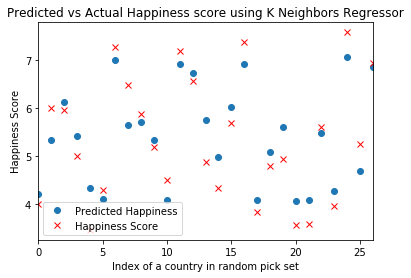

In [182]:
comp2015  = pd.concat([y2015_predict,y2015_test],axis=1)
comp2015 = comp2015[['Predicted Happiness','Happiness Score']]
ax = comp2015.plot(style=['o','rx'],title='Predicted vs Actual Happiness score using K Neighbors Regressor')
ax.set_xlabel('Index of a country in random pick set')
ax.set_ylabel('Happiness Score')

In [183]:
###########----------End of Prediction-------##############